# Density evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
# import libraries
!pip install opencv-python
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, kendalltau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading dataset

In [4]:
dataset_path='/content/drive/MyDrive/anemia-detection-main-modified/database_sclere/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to indian dataset
df = df[df['dataset']=='ind']

# Save the emoglobina values
df5coloumn = (df.iloc[:, 4])
emoglobina_strings = df5coloumn.to_numpy()
emoglobina_values = np.array([float(obj.replace(',', '.')) for obj in emoglobina_strings])

df.head()


,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
91,ind,1,20200118_164759,20200118_164733,"12,2",NaN,M,29,NaN,NaN,NaN
92,ind,2,20200124_154320,20200124_154319,8,NaN,F,36,NaN,NaN,NaN
93,ind,3,20200124_155439,20200124_155418,"10,7",NaN,F,30,NaN,NaN,NaN
94,ind,4,20200124_160524,20200124_160522,"8,3",NaN,F,39,NaN,NaN,NaN
95,ind,5,20200124_161455,20200124_161452,"7,8",NaN,F,29,NaN,NaN,NaN


# Loading photos

In [5]:
path_photos = dataset_path+'Dataset indiano/'
sclera_vessels = []
sclera_masks = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(row['paziente'] + "-") and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)
            sclera_vessels.append(sclera_vessel)
            break

100%|██████████| 95/95 [03:13<00:00,  2.04s/it]


# Preprocessing

100%|██████████| 95/95 [00:04<00:00, 23.00it/s]


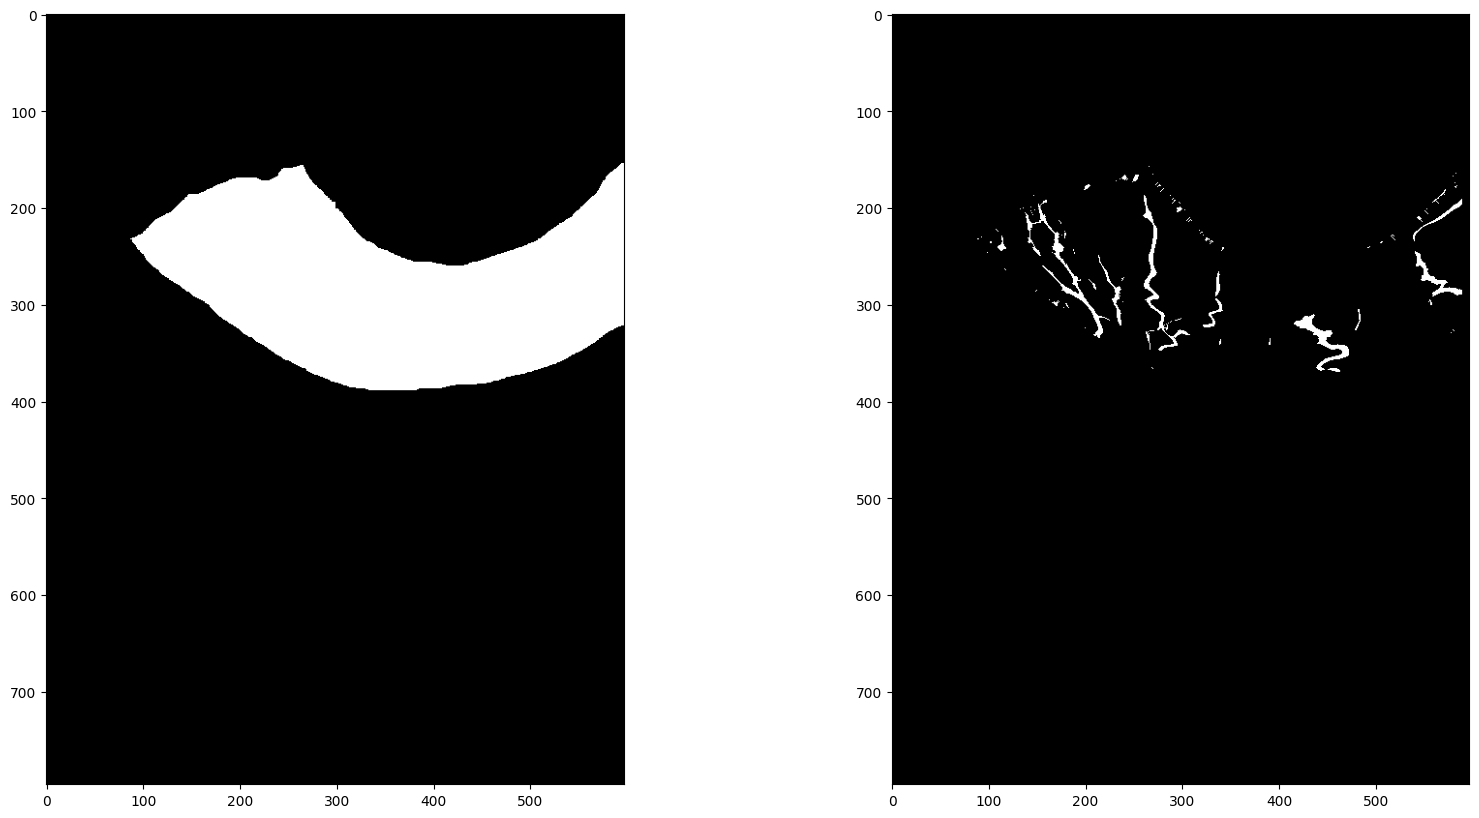

In [6]:
sclera_vessels_shape = sclera_vessels[0].shape
sclera_masks_bw = []                                # array of black and white sclera
sclera_vessels_bw = []                              # array of black and white sclera vessels

# converts the sclera masks to black and white
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    # resize the mask to the sclera vessel shape
    mask = cv2.resize(mask, sclera_vessels_shape[:2][::-1])
    
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_masks_bw.append(mask)

# converts the sclera vessels to black and white
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    # transparence becomes black
    mask[mask[:, :, 3] == 0] = [0, 0, 0, 0]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)
    
    sclera_vessels_bw.append(mask)

# show the sclera masks and sclera vessels
for i in range(1):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_masks_bw[i], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(sclera_vessels_bw[i], cmap='gray')
    plt.show()

# Mask application

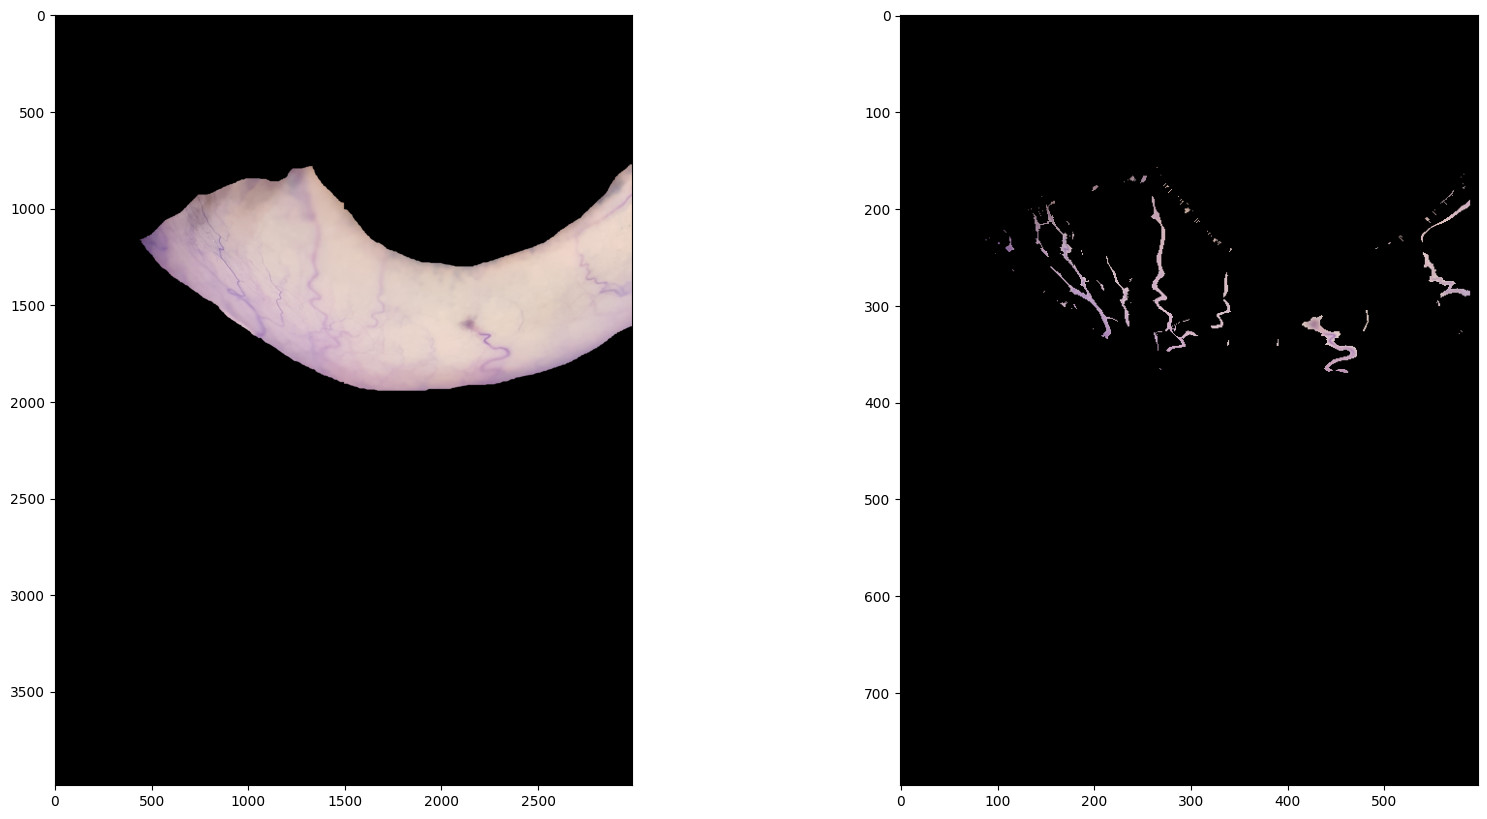

In [7]:
# sclera_masks = []                                # array of coulored sclera
# sclera_vessels = []                              # array of coulored sclera vessels

# sclera_masks_bw = []                                # array of black and white sclera
# sclera_vessels_bw = []                                # array of black and white sclera vessels

sclera_masked = []                                    # array of sclera with only sclera part is coloured
sclera_vessels_masked = []                            # array of sclera with only sclera part is coloured

for l in range (len(sclera_masks_bw)):                               # Per ogni maschera della sclera
    sclera_masked.append(sclera_masks[l])                            # Carica la foto orignale sull'array
    for i in range(sclera_masks_bw[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_masks_bw[l].shape[1]):                 # Itera sulle colonne
            if sclera_masks_bw[l][i, j] == 0:                        # Se il pixel della maschera è nero
                sclera_masked[l][i, j] = [0, 0, 0]                   # Rendi il pixel corrispondente della sclera nero
            else:                                                    # Altrimenti\n",
                sclera_masked[l][i, j] = sclera_masks[l][i, j]       # Rendi il pixel corrispondente della sclera del colore originale

for l in range (len(sclera_vessels_bw)):                                       # Per ogni maschera dei vasi
    sclera_vessels_masked.append(sclera_vessels[l])                            # Carica la foto orignale sull'array
    for i in range(sclera_vessels_bw[l].shape[0]):                             # Itera sulle righe
        for j in range(sclera_vessels_bw[l].shape[1]):                         # Itera sulle colonne
            if sclera_vessels_bw[l][i, j] == 0:                                # Se il pixel della maschera è nero
                sclera_vessels_masked[l][i, j] = [0, 0, 0, 255]                           # Rendi il pixel corrispondente della sclera nero
            else:                                                                    # Altrimenti
                sclera_vessels_masked[l][i, j] = sclera_vessels[l][i, j]       # Rendi il pixel corrispondente della sclera del colore originale
                
# Visualizza l'immagine risultante
for i in range(1):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_masked[i])
    plt.subplot(1, 2, 2)
    plt.imshow(sclera_vessels_masked[i])
    plt.show()                

# Metrics calculation (BGR)

In [8]:
# calculate the metrics
vessels_density = []
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0

b = 0
g = 0
r = 0
value_r_minous_g_pixel_sclera = 0
value_r_minous_g_img_sclera = []
value_r_minous_g_pixel_vessels = 0
value_r_minous_g_img_vessels = []
difference_rg_sclera = []
difference_rg_vessels = []
standard_deviation_sclera = []
standard_deviation_vessels = []

for l in range(len(sclera_masked)):                               # Per ogni immagine della sclera
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_r_minous_g_pixel_sclera = 0
    value_r_minous_g_pixel_vessels = 0
    difference_rg_sclera.clear ()
    difference_rg_vessels.clear ()
    
    for i in range(sclera_masked[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_masked[l].shape[1]):                 # Itera sulle colonne
            number_sclera_pixel += 1
            b = sclera_masked[l].item(i, j, 0)
            g = sclera_masked[l].item(i, j, 1)
            r = sclera_masked[l].item(i, j, 2)
            if not (b == 0 and g == 0 and r == 0):
                number_sclera_pixel_coulored +=1
                value_r_minous_g_pixel_sclera += r-g
                difference_rg_sclera.append(r-g)

                
    for i in range(sclera_vessels_masked[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_vessels_masked[l].shape[1]):                 # Itera sulle colonne
            number_vessels_pixel += 1
            b = sclera_vessels_masked[l].item(i, j, 0)
            g = sclera_vessels_masked[l].item(i, j, 1)
            r = sclera_vessels_masked[l].item(i, j, 2)
            if not (b == 0 and g == 0 and r == 0):
                number_vessels_pixel_coulored +=1
                value_r_minous_g_pixel_vessels += r-g
                difference_rg_vessels.append(r-g)
         
    vessels_density.append(number_vessels_pixel_coulored/number_sclera_pixel_coulored)
    print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_r_minous_g_img_sclera.append(value_r_minous_g_pixel_sclera/number_sclera_pixel)
    print("il valore medio dei pixel della sclera, calcolati come R - G, per la", l+1, "° immagine è: ",value_r_minous_g_img_sclera[l])
    value_r_minous_g_img_vessels.append(value_r_minous_g_pixel_vessels/number_vessels_pixel)
    print("il valore medio dei pixel dei vasi, calcolati come R - G, per la", l+1, "° immagine è: ", value_r_minous_g_img_vessels[l])
    standard_deviation_sclera.append(np.std(difference_rg_sclera))
    print("la deviazione standard, calcolata su R - G, per la", l+1, "° immagine della sclera è: ", standard_deviation_sclera[l])
    standard_deviation_vessels.append(np.std(difference_rg_vessels))
    print("la deviazione standard, calcolata su R - G, per la", l+1, "° immagine dei vasi è: ", standard_deviation_vessels[l])

il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la 1 ° immagine è:  0.0022698421420240286
il valore medio dei pixel della sclera, calcolati come R - G, per la 1 ° immagine è:  0.33853251022832964
il valore medio dei pixel dei vasi, calcolati come R - G, per la 1 ° immagine è:  0.14471225474104188
la deviazione standard, calcolata su R - G, per la 1 ° immagine della sclera è:  13.021297136383962
la deviazione standard, calcolata su R - G, per la 1 ° immagine dei vasi è:  12.59291952017628
il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la 2 ° immagine è:  0.002345971350423345
il valore medio dei pixel della sclera, calcolati come R - G, per la 2 ° immagine è:  -0.34999998319919573
il valore medio dei pixel dei vasi, calcolati come R - G, per la 2 ° immagine è:  0.08978308628569985
la deviazione standard, calcolata su R - G, per la 2 ° immagine della sclera è:  13.183499375020135
la deviazione standard, calcolata su R - G, per la 2 ° 


# Metrics calculation (L*a*b*)

In [ ]:
# Calculate the metrics
vessels_density_lab = []
sclera_lab = []
sclera_vessels_lab = []
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0
L = 0
a = 0
b = 0
value_a_pixel_sclera = 0
value_a_img_sclera = []
value_a_pixel_vessels = 0
value_a_img_vessels = []
difference_a_sclera = []
difference_a_vessels = []
standard_deviation_sclera_lab = []
standard_deviation_vessels_lab = []

for l in range (len(sclera_masked)):                               # Per ogni immagine della sclera
    sclera_lab.append(cv2.cvtColor(sclera_masked[l], cv2.COLOR_BGR2Lab))
    sclera_vessels_lab.append(cv2.cvtColor(sclera_vessels_masked[l], cv2.COLOR_BGR2Lab))

    
for l in range (len(sclera_lab)):                               # Per ogni immagine della sclera 
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_r_minous_g_pixel_sclera = 0
    value_r_minous_g_pixel_vessels = 0
    value_a_pixel_sclera = 0
    value_a_pixel_vessels = 0
    difference_a_sclera.clear ()
    difference_a_vessels.clear ()
    
    for i in range(sclera_lab[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_lab[l].shape[1]):                 # Itera sulle colonne
            number_sclera_pixel += 1
            L = sclera_lab[l].item(i, j, 0)
            a = sclera_lab[l].item(i, j, 1)
            b = sclera_lab[l].item(i, j, 2)
            if not (L == 0 and a == 128 and b == 128):
                number_sclera_pixel_coulored +=1
                value_a_pixel_sclera += a
                difference_a_sclera.append(a)

                
    for i in range(sclera_vessels_lab[l].shape[0]):                     # Itera sulle righe
        for j in range(sclera_vessels_lab[l].shape[1]):                 # Itera sulle colonne
            number_vessels_pixel += 1
            L = sclera_vessels_lab[l].item(i, j, 0)
            a = sclera_vessels_lab[l].item(i, j, 1)
            b = sclera_vessels_lab[l].item(i, j, 2)
            if not (L == 0 and a == 128 and b == 128):
                number_vessels_pixel_coulored +=1
                value_a_pixel_vessels += a
                difference_a_vessels.append(a)
         
    vessels_density_lab.append(number_vessels_pixel_coulored/number_sclera_pixel_coulored)
    print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_a_img_sclera.append(value_a_pixel_sclera/number_sclera_pixel)
    print("il valore medio dei pixel della sclera, calcolati come a*, per la", l+1, "° immagine è: ",value_a_img_sclera[l])
    value_a_img_vessels.append(value_a_pixel_vessels/number_vessels_pixel)
    print("il valore medio dei pixel dei vasi, calcolati come a*, per la", l+1, "° immagine è: ", value_a_img_vessels[l])
    standard_deviation_sclera_lab.append(np.std(difference_a_sclera))
    print("la deviazione standard, calcolata su a*, per la", l+1, "° immagine della sclera è: ", standard_deviation_sclera_lab[l])
    standard_deviation_vessels_lab.append(np.std(difference_a_vessels))
    print("la deviazione standard, calcolata su a*, per la", l+1, "° immagine dei vasi è: ", standard_deviation_vessels_lab[l])



for i in range(1):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_lab[i])
    plt.show()
   

# Preparazione di a* sclera

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_a_img_sclera[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_a_img_sclera")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_a_img_sclera")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_a_img_sclera[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione di a* vessels

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_a_img_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_a_img_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_a_img_vessels")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_a_img_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione di dev. stand. vasi Lab

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (standard_deviation_sclera_lab[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("standard_deviation_sclera_lab")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("standard_deviation_sclera_lab")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (standard_deviation_sclera_lab[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione di Standard_deviation_vessels_lab

In [93]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (standard_deviation_vessels_lab[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("standard_deviation_vessels_lab")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("standard_deviation_vessels_lab")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (standard_deviation_vessels_lab[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


Matrice addestramento
standard_deviation_vessels_lab
0 4.9632898059332256
1 3.8170710474941263
2 4.654071042925198
3 6.109011054809749
4 4.063464434801736
5 6.122805577224401
6 4.840435801342083
7 5.539463277410621
8 4.92535452396211
9 3.6829684407704852
10 5.357979112039536
11 2.38750166884488
12 6.7329562262511535
13 4.274732394437286
14 3.0397966816743134
15 4.1475668849751415
16 7.7467594027876645
17 5.7985320893353824
18 4.614100868309784
19 4.8862300044551965
20 5.610906723571329
21 4.428546778260575
22 4.513447920818571
23 4.7598411761175505
24 4.3391658549416885
25 3.4330462541839806
26 4.973643964241182
27 4.571749343517094
28 6.615069472144604
29 4.201550957164764
30 6.552807296746572
31 8.301132119795994
32 5.250153129692595
33 4.801814526815874
34 4.292492594722773
35 4.9612709452028785
36 5.811074507790897
37 4.87504203976979
38 6.782601609543155
39 5.89238232179087
40 3.764513952309
41 5.321726586920952
42 4.086059199286125
43 4.9593974520490365
44 5.006299611484516
45 7.

# Preparazione di a* sclera, a* vasi

In [95]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_a_img_sclera[i], value_a_img_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_a_img_sclera", "value_a_img_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_a_img_sclera", "value_a_img_vessels")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_a_img_sclera[i], value_a_img_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


Matrice addestramento
value_a_img_sclera value_a_img_vessels
0 (19.81767195959205, 1.178391959798995)
1 (19.789226181835776, 1.2404232216358173)
2 (13.657728386773332, 0.616840483826166)
3 (30.08648617226604, 1.6834570675824685)
4 (15.889516566937093, 1.0202183446545963)
5 (22.533633530104353, 1.6226926087725058)
6 (15.157352384773365, 0.4202882082102304)
7 (18.046646761073745, 1.4228091883201603)
8 (29.742488864426917, 2.589387473380302)
9 (11.490287203028984, 0.43403154802488153)
10 (26.420309753068498, 3.470295362911711)
11 (14.270977316226082, 0.37226963965556426)
12 (15.545052532754848, 0.474379855727549)
13 (13.770346614033107, 0.7649743693341077)
14 (18.999589640355264, 0.9109302795383954)
15 (21.50343937664984, 1.0271647180626753)
16 (17.70426451455084, 1.3775115106520879)
17 (24.733399041278904, 1.8537410671447692)
18 (14.714953858271103, 0.6636385444812)
19 (26.67195135965549, 1.8445872578975278)
20 (25.162295181394924, 2.775399190256138)
21 (15.27848240350962, 1.292023349578

# Preparazione di a* sclera, a* vasi, dev. stand. vasi

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_a_img_sclera[i], value_a_img_vessels[i], standard_deviation_sclera_lab[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_a_img_sclera", "value_a_img_vessels", "standard_deviation_sclera_lab")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_a_img_sclera", "value_a_img_vessels", "standard_deviation_sclera_lab")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_a_img_sclera[i], value_a_img_vessels[i], standard_deviation_sclera_lab[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione di tutti i parametri Lab

In [97]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (vessels_density[i], value_a_img_sclera[i], value_a_img_vessels[i], standard_deviation_sclera_lab[i], standard_deviation_vessels_lab[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("vessels_density", "value_a_img_sclera", "value_a_img_vessels", "standard_deviation_sclera_lab", "standard_deviation_vessels_lab")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("vessels_density", "value_a_img_sclera", "value_a_img_vessels", "standard_deviation_sclera_lab", "standard_deviation_vessels_lab")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (vessels_density[i], value_a_img_sclera[i], value_a_img_vessels[i], standard_deviation_sclera_lab[i], standard_deviation_vessels_lab[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


Matrice addestramento
vessels_density value_a_img_sclera value_a_img_vessels standard_deviation_sclera_lab standard_deviation_vessels_lab
0 (0.0022698421420240286, 19.81767195959205, 1.178391959798995, 5.329159474040933, 4.9632898059332256)
1 (0.002345971350423345, 19.789226181835776, 1.2404232216358173, 4.498408739738694, 3.8170710474941263)
2 (0.002187751278741252, 13.657728386773332, 0.616840483826166, 5.261266818503929, 4.654071042925198)
3 (0.0021561557932335625, 30.08648617226604, 1.6834570675824685, 5.7261942610805985, 6.109011054809749)
4 (0.002208397761404051, 15.889516566937093, 1.0202183446545963, 4.062442975017821, 4.063464434801736)
5 (0.002297865912548322, 22.533633530104353, 1.6226926087725058, 6.03267798205984, 6.122805577224401)
6 (0.00216119552355425, 15.157352384773365, 0.4202882082102304, 4.827504977099859, 4.840435801342083)
7 (0.0022578573865847645, 18.046646761073745, 1.4228091883201603, 5.255216286493938, 5.539463277410621)
8 (0.002426309566692011, 29.7424888644

# Preparazione di r-g sclera, r-g vasi, dev. stand. vasi

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i], standard_deviation_sclera[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels", "standard_deviation_sclera")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels", "standard_deviation_sclera")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i], standard_deviation_sclera[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione di r-g sclera, r-g vasi

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione tutti parametri BGR

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (vessels_density[i], value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i], standard_deviation_sclera[i], standard_deviation_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("vessels_density", "value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels", "standard_deviation_sclera", "standard_deviation_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("vessels_density", "value_r_minous_g_img_sclera", "value_r_minous_g_img_vessels", "standard_deviation_sclera", "standard_deviation_vessels")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (vessels_density[i], value_r_minous_g_img_sclera[i], value_r_minous_g_img_vessels[i], standard_deviation_sclera[i], standard_deviation_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione vessels_density pazienti

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (vessels_density[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("vessels_density")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("vessels_density")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (vessels_density[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione value_r_minous_g_img_sclera pazienti

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_r_minous_g_img_sclera[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_r_minous_g_img_sclera")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_r_minous_g_img_sclera")
for i in range(80,95): #(len(sclera_masked)):
  paziente_test = (value_r_minous_g_img_sclera[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione value_r_minous_g_img_vessels pazienti

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (value_r_minous_g_img_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("value_r_minous_g_img_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("value_r_minous_g_img_vessels")
for i in range (80,95): #(len(sclera_masked)):
  paziente_test = (value_r_minous_g_img_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione standard_deviation_sclera pazienti


In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (standard_deviation_sclera[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("standard_deviation_sclera")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("standard_deviation_sclera")
for i in range (80,95): #(len(sclera_masked)):
  paziente_test = (standard_deviation_sclera[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Preparazione standard_deviation_vessels pazienti

In [ ]:
pazienti = []
pazienti_test = []
for i in range(80):
  paziente = (standard_deviation_vessels[i])
  pazienti.append(paziente)

print("Matrice addestramento")
print("standard_deviation_vessels")
for i in range (len(pazienti)):
  print( i , pazienti[i])

print("\n\n")

print("Matrice test")
print("standard_deviation_vessels")
for i in range (80,95): #(len(sclera_masked)):
  paziente_test = (standard_deviation_vessels[i])
  pazienti_test.append(paziente_test)

for i in range (len(pazienti_test)):
  print( i , pazienti_test[i])


# Regressione lineare, coeff di correlazione e grafico per più metriche

Dati di train:
[(0.0022698421420240286, 19.81767195959205, 1.178391959798995, 5.329159474040933, 4.9632898059332256), (0.002345971350423345, 19.789226181835776, 1.2404232216358173, 4.498408739738694, 3.8170710474941263), (0.002187751278741252, 13.657728386773332, 0.616840483826166, 5.261266818503929, 4.654071042925198), (0.0021561557932335625, 30.08648617226604, 1.6834570675824685, 5.7261942610805985, 6.109011054809749), (0.002208397761404051, 15.889516566937093, 1.0202183446545963, 4.062442975017821, 4.063464434801736), (0.002297865912548322, 22.533633530104353, 1.6226926087725058, 6.03267798205984, 6.122805577224401), (0.00216119552355425, 15.157352384773365, 0.4202882082102304, 4.827504977099859, 4.840435801342083), (0.0022578573865847645, 18.046646761073745, 1.4228091883201603, 5.255216286493938, 5.539463277410621), (0.002426309566692011, 29.742488864426917, 2.589387473380302, 6.407939020962678, 4.92535452396211), (0.0023693216094540386, 11.490287203028984, 0.43403154802488153, 3.6

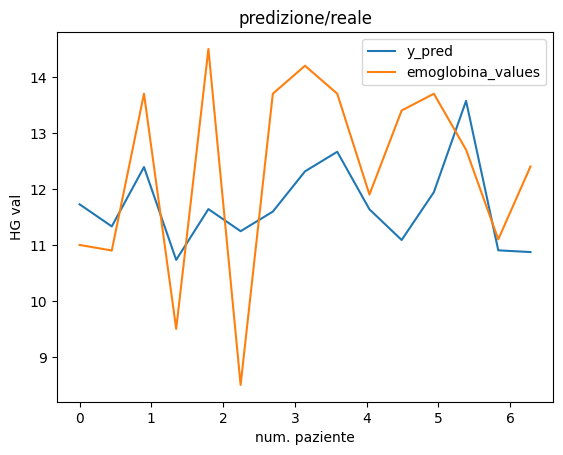

Coefficiente di correlazione di Pearson: 0.48587756823628786
Coefficiente di correlazione di Spearman: 0.5711943513489843
Coefficiente di correlazione di Kendall: 0.3825184261187248


In [98]:

# Dati di addestramento
X_train = pazienti                              # Esempio di variabili indipendenti (features)
y_train = np.array(emoglobina_values[:80])       #
                    
# Creazione e addestramento del modello di regressione lineare
model = LinearRegression()
model.fit(X_train, y_train)

# Dati di test
X_test = pazienti_test

# Previsione dei valori
y_pred = model.predict(X_test)

# Stampa dei risultati
print("Dati di train:")
print(X_train)
print("Emoblobina di test:")
print(y_train)

print("\n\n\n")

print("Dati di test:")
print(X_test)
print("Previsioni:")
print(y_pred)
print("Risultati reali:")
print(emoglobina_values[80:95])


#Grafico & Coeff di correlazione
x = np.linspace(0, 2*np.pi, 15)
y1 = y_pred
y2 = emoglobina_values[80:95]
correlazione = np.corrcoef(y1, y2)[0, 1]

# Creazione del grafico
plt.plot(x, y1, label='y_pred')
plt.plot(x, y2, label='emoglobina_values')

# Aggiunta di titoli e legenda
plt.title('predizione/reale')
plt.xlabel('num. paziente')
plt.ylabel('HG val')
plt.legend()

# Visualizzazione del grafico
plt.show()

# Calcolo del coefficiente di correlazione di Pearson
corr_pearson = np.corrcoef(y1, y2)[0, 1]
# Calcolo del coefficiente di correlazione di Spearman
corr_spearman, _ = spearmanr(y1, y2)
# Calcolo del coefficiente di correlazione di Kendall
corr_kendall, _ = kendalltau(y1, y2)

print("Coefficiente di correlazione di Pearson:", corr_pearson)
print("Coefficiente di correlazione di Spearman:", corr_spearman)
print("Coefficiente di correlazione di Kendall:", corr_kendall)

# Modello di regressione e coeff. di correlazione per singola metrica

In [ ]:
# Dati di addestramento
X_train = pazienti                              # Esempio di variabili indipendenti (features)

X_train = np.array(X_train)
X_train = X_train.reshape(-1, 1)


y_train = np.array(emoglobina_values[:80])       #
                    
# Creazione e addestramento del modello di regressione lineare
model = LinearRegression()
model.fit(X_train, y_train)

# Dati di test
X_test = pazienti_test

X_test = np.array(X_test)
X_test = X_test.reshape(-1, 1)
# Previsione dei valori
y_pred = model.predict(X_test)

# Stampa dei risultati
print("Dati di train:")
print(X_train)
print("Emoblobina di test:")
print(y_train)

print("\n\n\n")

print("Dati di test:")
print(X_test)
print("Previsioni:")
print(y_pred)
print("Risultati reali:")
print(emoglobina_values[80:95])

y1 = y_pred.reshape(1, -1)
y1 = y1.tolist()
y2 = emoglobina_values[80:95]

# Calcolo del coefficiente di correlazione di Pearson
corr_pearson = np.corrcoef(y1, y2)[0, 1]
print("Coefficiente di correlazione di Pearson:", corr_pearson)

